# Gauging $P$ Quality: Local Mock Cycle (LMC) vs. Local Two-level Cycle (L2C)
For constant $k$ (repetitive equations):
* Compare local two-level cycle and (local) mock cycle convergence rates to determine if $P$ is good or caliber needs to be increased.
* First approximation to $P = R^T$ where $R$ = SVD coarsening.

We compare $kh = 0$ with GS, 2/1 coarsening and $kh = 0.5$ with Kaczmarz, 4/2, 6/2 and 6/3 coarsening cases.

In [1]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import helmholtz.repetitive.coarsening_repetitive as hrc
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

In [2]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Domain size.
n = 96 # 384 # 192 #96

kh = 0.5
num_sweeps = 80
aggregate_size = 6
num_components = 2

# Repetitive framework.
repetitive = True
# Number of test vectors.
num_examples = 3

nu_values = np.arange(1, 7)

## Coarsening $R$ and LMC Rate

In [3]:
def mock_conv_factor(kh, n, aggregate_size, num_components, num_sweeps: int = 5):
    # 'num_sweeps': number of relaxation sweeps to relax the TVs and to use in coarsening optimization
    # (determined by relaxation shrinkage).

    # Create fine-level matrix.
    a = hm.linalg.helmholtz_1d_operator(kh, n)
    # Use default Kacmzarz for kh != 0.
    level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    # For A*x=b cycle tests.
    b = np.random.random((a.shape[0], ))

    # Create relaxed vectors.
    x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
    b = np.zeros_like(x)
    x, _ = hm.solve.run.run_iterative_method(level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)

    # Construct coarsening on an aggregate.
    x_aggregate_t = np.concatenate(
        tuple(hm.linalg.get_window(x, offset, aggregate_size)
              for offset in range(max((4 * aggregate_size) // x.shape[1], 1))), axis=1).transpose()

    # Tile the same coarsening over all aggregates.
    r, s = hm.setup.coarsening_uniform.create_coarsening(x_aggregate_t, num_components)
    r = hrc.Coarsener(r)
    print("kh", kh, "a", aggregate_size, "nc", num_components, "#TV sweeps",
          num_sweeps, "#windows", x_aggregate_t.shape[0], "r", r.asarray(), "s", s)

    # Calculate mock cycle convergence rate.
    m_values = np.arange(2, 11, dtype=int)
    mock_conv = pd.DataFrame(np.array([
        mock_conv_factor_for_domain_size(kh, r, aggregate_size, m * aggregate_size, nu_values)
        for m in m_values]),
            index=m_values, columns=nu_values)

    return r, mock_conv

def mock_conv_factor_for_domain_size(kh, r, aggregate_size, m, nu_values):
    """Returns thre mock cycle conv factor for a domain of size m instead of n."""
    # Create fine-level matrix.
    a = hm.linalg.helmholtz_1d_operator(kh, m)
    # Use default Kacmzarz for kh != 0.
    level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    r_csr = r.tile(m // aggregate_size)
    return np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, r_csr, nu) for nu in nu_values])

In [4]:
# cases = [
#     (0, 2, 1, 5),      # Laplace
#     (0.5, 4, 2, 5),    # kh=0.5, 4/2
#     (0.5, 6, 3, 5),    # kh=0.5, 6/3
#     (0.5, 6, 2, 5),    # kh=0.5, 6/2 (Karsten found it to be good)
#     (0.5, 6, 2, 200),    # kh=0.5, 6/2 (Karsten found it to be good)
# ]
# case_conv = [mock_conv_factor(*case) for case in cases]

In [5]:
r, mock_conv = mock_conv_factor(kh, n, aggregate_size, num_components, num_sweeps=num_sweeps)
mock_conv[:5]

kh 0.5 a 6 nc 2 #TV sweeps 80 #windows 24 r [[-0.538 -0.593 -0.488 -0.268 -0.004  0.222]
 [ 0.328  0.002 -0.301 -0.504 -0.563 -0.48 ]] s [0.181 0.138 0.02  0.005 0.    0.   ]


,1,2,3,4,5,6
2,0.75,0.75,0.63,0.53,0.43,0.35
3,0.73,0.76,0.65,0.54,0.44,0.36
4,0.86,0.73,0.65,0.55,0.45,0.37
5,0.78,0.76,0.66,0.55,0.46,0.37
6,0.87,0.77,0.66,0.54,0.46,0.38


NameError: name 'row' is not defined

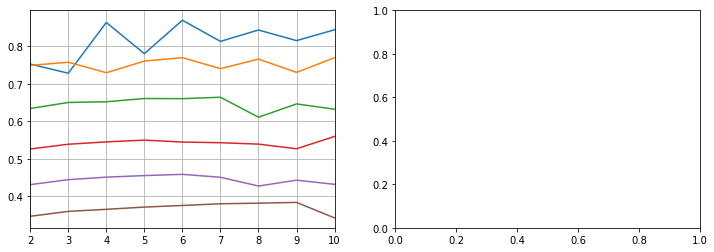

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

a, nc, conv = aggregate_size, num_components, mock_conv
# Mock cycle convergence vs. domain size [aggregates] and nu=1,...,6.
#print("kh {} a {} nc {} num_sweeps {}".format(kh, a, nc, num_sweeps))
#display(conv[:10])

ax_row = axs[row] if axs.ndim > 1 else axs
error = (conv - conv.iloc[-1]) / conv.iloc[-1]
nu_values = conv.columns
m_values = conv.index

ax = ax_row[0]
for nu in nu_values:
    ax.plot(m_values, conv[nu], label="$\\nu = {}$".format(nu))
ax.grid(True);
ax.set_xlim([2, 10]);
if row == len(cases) - 1:
    ax.set_xlabel("Domain Size [aggregates]")
ax.set_ylabel("$kh {}$ a {} nc {} #sweeps {}".format(kh, a, nc, num_sweeps))
if row == 0:
    ax.set_title("Mock Cycle Conv Factor");
ax.legend();

ax = ax_row[1]
for nu in nu_values:
    ax.plot(m_values, error[nu], label="$\\nu = {}$".format(nu))
ax.grid(True);
ax.set_xlim([2, 10]);
if row == len(cases) - 1:
    ax.set_xlabel("Domain Size [aggregates]")
if row == 0:
    ax.set_title("Relative Deviation from Asymptotic Value");
ax.legend();

$3-4$ aggregates are enough to show the mock cycle rate on the full domain.

## Two-level Cycle Rate with $P = R^T$

In [7]:
p = r.tile(1).transpose()
print(p.todense())

# caliber = 1
# p = hm.setup.auto_setup.create_interpolation(
#     x_level, level.a, r, interpolation_method, aggregate_size=aggregate_size, nc=nc, max_caliber=max_caliber,
#     neighborhood=neighborhood, repetitive=repetitive, target_error=target_error)
# for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
#     error = norm(x_set - p.dot(r.dot(x_set)), axis=0) / norm(x_set, axis=0)
#     error_a = norm(level.a.dot(x_set - p.dot(r.dot(x_set))), axis=0) / norm(x_set, axis=0)
#     _LOGGER.info(
#         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
#             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

[[-0.538  0.328]
 [-0.593  0.002]
 [-0.488 -0.301]
 [-0.268 -0.504]
 [-0.004 -0.563]
 [ 0.222 -0.48 ]]


In [8]:
def create_two_level_hiearchy(kh, m, r, p):
    a = hm.linalg.helmholtz_1d_operator(kh, m)
    r_csr = r.tile(m // aggregate_size)
    p_csr = hm.linalg.tile_array(p, m // aggregate_size)
    level0 = hm.setup.hierarchy.create_finest_level(a) #, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    level1 = hm.setup.hierarchy.create_coarse_level(level0.a, level0.b, r_csr, p_csr)
    multilevel = hm.hierarchy.multilevel.Multilevel.create(level0)
    multilevel.add(level1)
    return multilevel

def two_level_conv_factor(multilevel, nu, print_frequency: int = None):
    level = multilevel.finest_level
    n = level.size
    # Test two-level cycle convergence for A*x=b with random b.
    b = np.random.random((n, ))
    two_level_cycle = lambda y: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 0, nu_coarsest=-1, debug=False, rhs=b).run(y)
    residual = lambda x: b - multilevel[0].operator(x)
    return hm.solve.run.run_iterative_method(
        residual, two_level_cycle, np.random.random((n, )), 15, print_frequency=print_frequency)

In [9]:
# display(pd.DataFrame(multilevel[0].a.todense()[:10,:10]))
# display(pd.DataFrame(multilevel[1].r[:10,:10].todense()))
# display(pd.DataFrame(multilevel[1].p[:10,:10].todense()))
# display(pd.DataFrame(multilevel[1].a[:10,:10].todense()))

### Solving $Ax = b$ - Convergence History

INFO         0 |r| 7.149e+00 RER 1.38724
INFO         1 |r| 1.220e+01 (1.70676) RER 0.28824 (0.20778) 42.334
INFO         2 |r| 5.732e+00 (0.46979) RER 0.20366 (0.70659) 28.147
INFO         3 |r| 3.193e+00 (0.55705) RER 0.12116 (0.59488) 26.357
INFO         4 |r| 1.577e+00 (0.49377) RER 0.06584 (0.54343) 23.948
INFO         5 |r| 7.782e-01 (0.49356) RER 0.03283 (0.49864) 23.704
INFO         6 |r| 3.682e-01 (0.47312) RER 0.01578 (0.48057) 23.336
INFO         7 |r| 1.616e-01 (0.43900) RER 0.00693 (0.43951) 23.309
INFO         8 |r| 8.158e-02 (0.50472) RER 0.00350 (0.50510) 23.292
INFO         9 |r| 4.386e-02 (0.53757) RER 0.00188 (0.53683) 23.324
INFO        10 |r| 2.641e-02 (0.60223) RER 0.00113 (0.60186) 23.338
INFO        11 |r| 1.479e-02 (0.56008) RER 0.00063 (0.55981) 23.349
INFO        12 |r| 7.684e-03 (0.51948) RER 0.00033 (0.51938) 23.354
INFO        13 |r| 3.691e-03 (0.48039) RER 0.00016 (0.48033) 23.357
INFO        14 |r| 1.724e-03 (0.46696) RER 0.00007 (0.46694) 23.358
INFO   

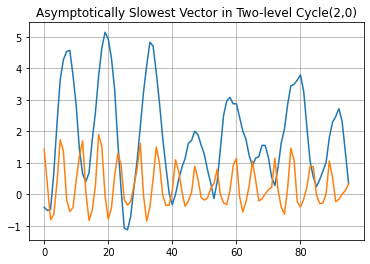

In [11]:
nu = 2
multilevel = create_two_level_hiearchy(kh, n, r, p)
y, _ = two_level_conv_factor(multilevel, nu, print_frequency=1)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y);
plt.plot(e);
plt.grid(True);

### Level Operator Spectra

In [12]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:12])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

0 lam [-0.018 -0.018  0.044  0.044 -0.087 -0.087  0.098  0.098  0.144  0.144 -0.163 -0.163]
1 lam [-0.019  0.029  0.029 -0.037  0.058  0.058  0.074  0.074  0.082  0.082  0.087  0.087]


### Local Two-level Cycle Rate

In [16]:
# Calculate two-level cycle convergence rate vs. domain size.
nu_values= np.arange(1, 11)
m_values = np.arange(1, 11, dtype=int)
two_level_conv = pd.DataFrame(np.array([
    [two_level_conv_factor(create_two_level_hiearchy(kh, m * aggregate_size, r, p), nu)[1]
     for nu in nu_values]
    for m in m_values]),
        index=m_values, columns=nu_values)
two_level_conv

,1,2,3,4,5,6,7,8,9,10
1,0.84,0.62,0.46,0.40,0.32,0.25,0.32,0.46,0.59,0.68
2,0.65,0.55,0.46,0.48,0.47,0.49,0.49,0.47,0.58,0.68
3,0.54,0.51,0.44,0.35,0.38,0.37,0.40,0.46,0.58,0.68
4,0.59,0.51,0.48,0.47,0.48,0.49,0.49,0.50,0.58,0.68
5,0.70,0.50,0.40,0.34,0.43,0.47,0.50,0.54,0.59,0.68
6,0.68,0.51,0.50,0.46,0.47,0.49,0.52,0.55,0.59,0.68
7,0.67,0.50,0.40,0.37,0.43,0.42,0.49,0.52,0.59,0.68
8,0.71,0.51,0.50,0.46,0.44,0.49,0.49,0.52,0.59,0.68
9,0.69,0.50,0.39,0.39,0.41,0.47,0.47,0.50,0.58,0.68
10,0.71,0.51,0.39,0.43,0.47,0.48,0.49,0.52,0.59,0.68


* Again, looks like $3-4$ aggregates are sufficient to get a constant two-level rate, provided that $P$ is good enough (i.e. (a) TVs are sufficiently smooth -- in this $n=96$ domain case, passed $80$ relaxation sweeps, and (b) the caliber is sufficiently large).
* $P = R^T$ does not attain the mock cycle rates beyond $\nu=2, ACF=0.3$.

## $P$ by LS fitting + Bootstrapping

In [708]:
max_levels = 2
num_bootstrap_steps = 1

# Create initial relaxed TVs.
a = hm.linalg.helmholtz_1d_operator(kh, n)
level = hm.setup.hierarchy.create_finest_level(a)
multilevel = hm.hierarchy.multilevel.Multilevel.create(level)
x = hm.solve.run.random_test_matrix((n,), num_examples=num_examples)
b = np.zeros_like(x)
x, _ = hm.solve.run.run_iterative_method(level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method="ls", 
        neighborhood="aggregate", repetitive=repetitive, target_error=0.1)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.913 asymptotic RQ 0.160 RER 0.211 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 2 nc 1 cr 0.50 mean_energy_error 0.0822; mock cycle num_sweeps 80 conv 0.06 eff 0.98
INFO     Mock cycle conv factor [0.542 0.227 0.217 0.068] for nu [ 1  2  3 80]
INFO     caliber 1 error l2 [0.25] a [19.92]
INFO     caliber 2 error l2 [0.03] a [0.3]
INFO     all  set size 3  P L2 error mean 0.03 max 0.04 A error mean 0.01 max 0.02
INFO     Level 1 size 48
INFO     RER 0.037486
INFO     --------------------------------------------------------------------------------


In [706]:
# Calculate two-level cycle convergence rate vs. domain size.
m_values = np.arange(2, 11, dtype=int)
two_level_conv = pd.DataFrame(np.array([
    [two_level_conv_factor(create_two_level_hiearchy(kh, m * aggregate_size, r, p), nu)[1]
     for nu in nu_values]
    for m in m_values]),
        index=m_values, columns=nu_values)
two_level_conv

,1,2,3,4,5,6
2,0.50,0.31,0.35,0.35,0.31,0.24
3,0.46,0.32,0.32,0.35,0.33,0.26
4,0.47,0.30,0.35,0.35,0.34,0.28
5,0.46,0.29,0.33,0.35,0.34,0.28
6,0.46,0.29,0.35,0.35,0.35,0.28
7,0.45,0.28,0.32,0.36,0.35,0.28
8,0.44,0.28,0.32,0.36,0.35,0.29
9,0.45,0.29,0.33,0.36,0.36,0.29
10,0.46,0.30,0.33,0.36,0.36,0.29


In [713]:
multilevel[1].p[:aggregate_size].todense()

matrix([[0.587, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.22 ],
        [0.596, 0.212, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.22 , 0.587, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   